In [1]:
import nzshm_utils
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
import numpy as np
import time
import os
os.chdir("/home/jovyan/notebooks/")
os.getcwd()

'/home/jovyan/notebooks'

In [2]:
# file_name= '../logs/inversionlogging_1024_gzip_100k/solution.parquet'
# column_name = 'solution'
file_name= '../logs/inversionlogging_1024_gzip_100k/misfits.parquet'
column_name = 'misfits'

# print file metadata
parquet_file = pq.ParquetFile(file_name)
print(parquet_file.metadata)
print(parquet_file.schema)

  created_by: parquet-mr version 1.15.1 (build c7257b8faff5699e13bbc781679dc03f48c1102a)
  num_columns: 1
  num_rows: 100001
  num_row_groups: 1001
  format_version: 1.0
  serialized_size: 165405
required group field_id=-1 misfits {
  required group field_id=-1 misfits (List) {
    repeated double field_id=-1 array;
  }
}



In [3]:
# groups with processses

def computation(previous, row):
  count = np.count_nonzero(row)
  previousNonZero = previous != 0
  nonZero = row != 0
  ids = np.logical_and(previousNonZero, nonZero)
  data_p = previous[ids]
  data_c = row[ids]
  data = (data_c - data_p)/data_p
  mean= np.mean(data)
  median = np.median(data)
  xor = np.logical_xor(previousNonZero, nonZero)
  added = np.count_nonzero(row[xor])
  removed = np.count_nonzero(previous[xor])
  return np.array([count, added, removed, mean, median])

start_time = time.time()     
result = nzshm_utils.parquet_iterator_parallel(file_name, column_name, computation, 5)
print(time.time() - start_time)


2.98073410987854


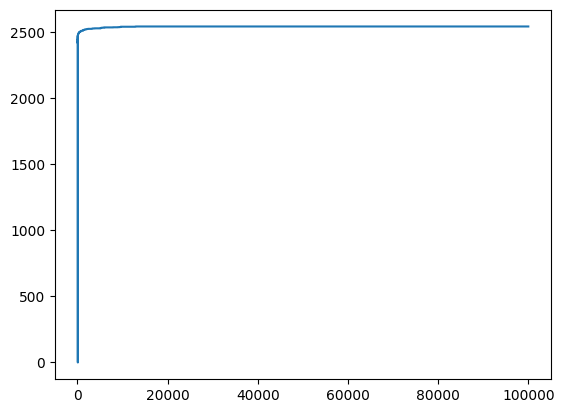

In [4]:
plt.plot(result[0])


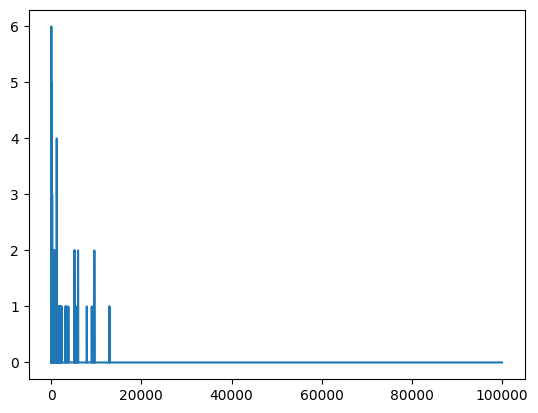

In [5]:
plt.plot(result[1])

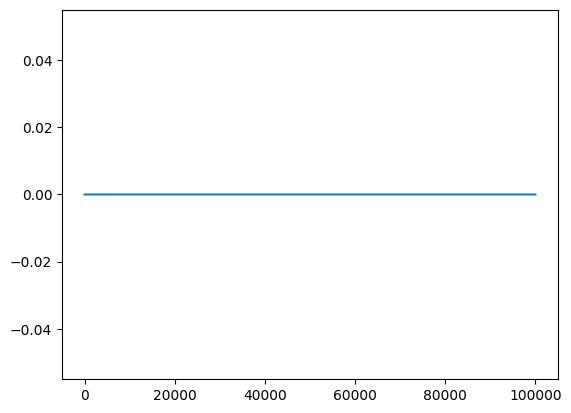

In [6]:
plt.plot(result[2])

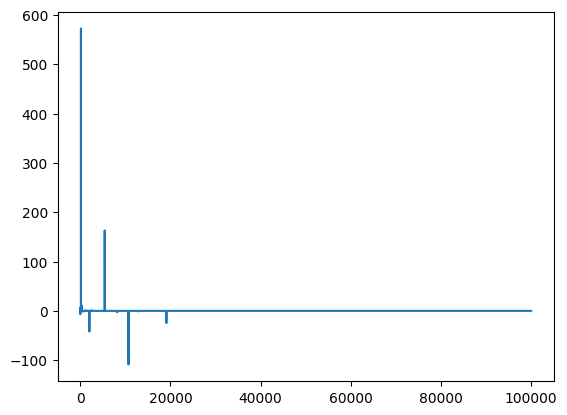

In [7]:
plt.plot(result[3])


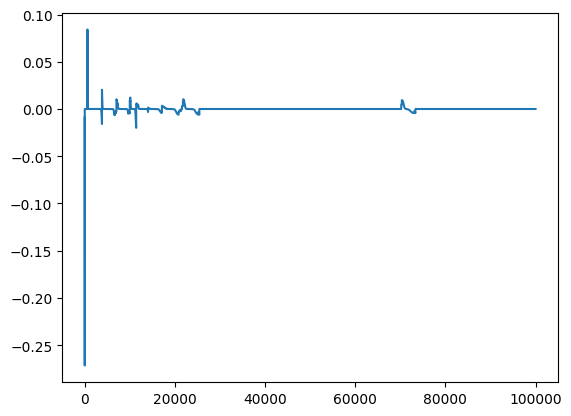

In [8]:
plt.plot(result[4])